In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

In [2]:
def enrichment_score(signal, exon_score=1):
    Nr = np.sum(signal)
    #exon_score = [1]*len(signal)
    denominator = len(signal) - np.sum(np.array(signal)>0)
    
    p_hit = []
    p_miss = []
    current_p_hit = 0
    current_p_miss = 0
    for i in range(len(signal)):
        if signal[i] > 0:
            current_p_hit += signal[i]/Nr
        else:
            current_p_miss += 1/denominator
        
        p_hit.append(current_p_hit)
        p_miss.append(current_p_miss)
        
    p_hit = np.array(p_hit)
    p_miss = np.array(p_miss)
    return p_hit-p_miss
    
def gsea(signal, permutations=2000):
    ES = np.max(enrichment_score(signal))
    ES_random = []
    for i in tqdm(range(permutations)):
        random_signal = np.random.choice(signal, len(signal), replace=False)
        ES_random.append(np.max(enrichment_score(random_signal)))
        
    ES_random = np.array(ES_random)
    p_val = (np.sum(ES_random >= ES)+1)/(permutations+1)
    return ES, p_val

def hyper_test(M, n, N, k):
    '''
    Calculates the hypergeometric test.
    
    Input:
      M: Population size (total exons tested)
      n: Successess in population (exons with p-value <= x)
      N: Sample size (exons selected)
      k: Successes in sample (selected exons with p-value <= x)
    Output:
      p_depleted: p-value of depletion from the hypergeometric test
      p_enriched: p-value of enrichment from the hypergeometric test
    '''
    hpd = hypergeom(M, n, N) # Hypergeometric distribution
    p_depleted = hpd.cdf(k)  # Get cummulative distribution up to k
    p_enriched = hpd.sf(k-1) # Survival function up to k-1 (1 - cdf(k-1))
    return p_depleted, p_enriched


def test_enrichment(binding, exon_cluster):
    M = len(binding)
    n = binding.sum()
    N = len(exon_cluster)
    k = binding.loc[exon_cluster].sum()
    p_depleted, p_enriched = hyper_test(M, n, N, k)
    
    enrichment = (k/N)/(n/M)
    
    if enrichment == 0:
        log_enrich = -3
    else:
        log_enrich = np.log2(enrichment)
        
    
    return p_enriched, p_depleted, log_enrich

from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

def get_background(counts, manifold, n_neighbors=100, remove_self=True):
    
    gene_list = counts.index
    
    n_genes = len(gene_list)
    n_cells = len(psi.index)
    
    knn_neighbors = NearestNeighbors(n_neighbors=n_neighbors).fit(manifold)
    distances, indices = knn_neighbors.kneighbors(manifold)
    
    if remove_self:
        distances = distances[:,1:]
        indices = indices[:,1:]

    sigma_array = np.max(distances, axis=1)
    
    weights = np.exp(-(distances**2)/(sigma_array**2).reshape(len(counts.columns),1))
    
    smooth_gene = pd.DataFrame()
    
    print('slicing exons...')
    pandas_slices = []
    for idx in indices:
        pandas_slices.append(counts.loc[gene_list].T.iloc[idx].to_numpy())

    pandas_slices = np.array(pandas_slices)

    for i in tqdm(range(len(gene_list)), position=0, leave=True):
        gene = gene_list[i]

        
        neighbors_gene = pandas_slices[:,:,i]
        

        background = np.nansum(neighbors_gene*weights, axis=1)/((~np.isnan(np.array(neighbors_gene)))*weights).sum(axis=1)


        smooth_gene[gene] = background

    smooth_gene.index = counts.columns
    
    return smooth_gene
    


# Neurogenesis modules

In [3]:
psix_results = pd.read_csv('psix_object/psix_results.tab.gz', sep='\t', index_col=0)
modules = pd.read_csv('psix_object/modules.tab.gz', sep='\t', index_col=0)
norm_expression = pd.read_csv('data/preprocess/tables/scone_norm_tpm_extended.tab.gz', sep='\t', index_col=0)
psi =  pd.read_csv('data/preprocess/tables/psi.tab.gz', sep='\t', index_col=0)
neighbors_psi = pd.read_csv('data/preprocess/tables/neighbors_psi.tab.gz', sep='\t', index_col=0)
latent = pd.read_csv('data/preprocess/tables/pc2_rd.tab.gz', sep='\t', index_col=0)

from sklearn.preprocessing import StandardScaler
scaled_counts = pd.DataFrame(StandardScaler().fit_transform(norm_expression.T).T)
scaled_counts.index = norm_expression.index
scaled_counts.columns = norm_expression.columns

In [4]:
clip_dir = '../rbp_binding/'
mouse_clip_overlap = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab.gz', sep='\t', index_col=0)
exon_length = pd.read_csv(clip_dir + 'exon_lengths.tab.gz', sep='\t', index_col=0, names=['ase', 'length'])

mouse_clip_overlap = mouse_clip_overlap.divide(exon_length.length, axis=0)

In [5]:
gsea(mouse_clip_overlap.loc[[x + '_e1' for x in psix_results.index]].NOVA1)

100%|██████████| 2000/2000 [00:05<00:00, 373.08it/s]


(0.21940211673613885, 0.0004997501249375312)

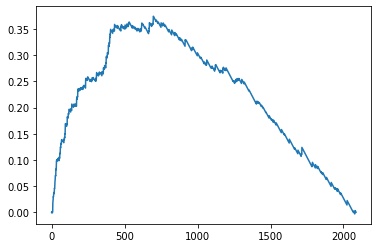

In [6]:
plt.plot(range(len(psix_results)),
    enrichment_score(mouse_clip_overlap.loc[[x + '_se' for x in psix_results.index]].NOVA1))

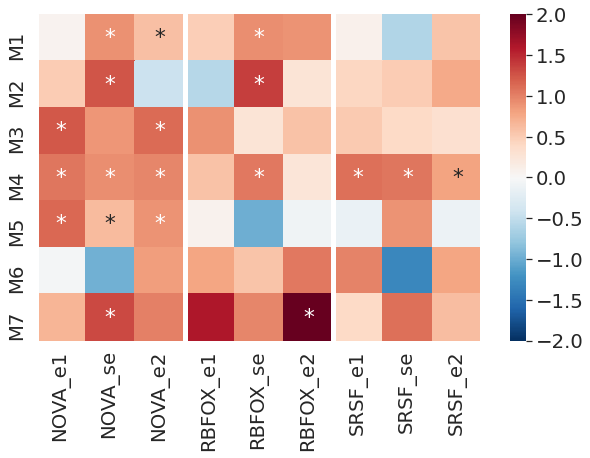

In [7]:

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab.gz', sep='\t', index_col=0) > 0).astype(int)
# mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags.tab.gz', sep='\t', index_col=0)
se_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_se']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']

mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_se'] = np.array(mouse_clip_peaks.loc[se_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))


mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_se')]

modules = pd.read_csv('psix_object/modules.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 8):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 8)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 8)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 8)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(7,-7)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''

sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

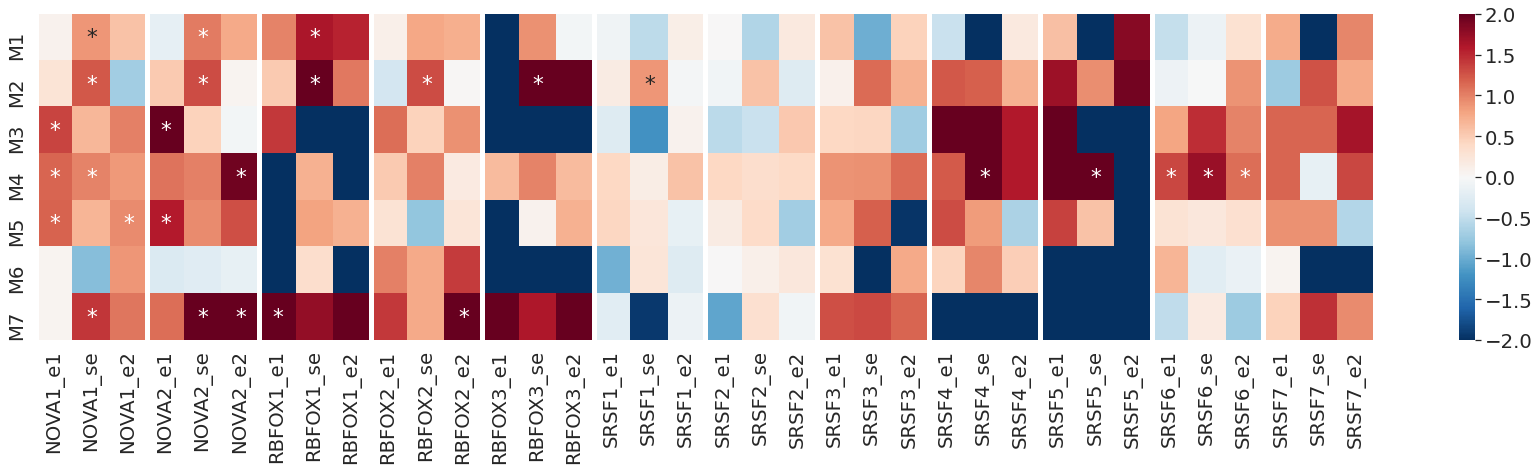

In [8]:
mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA1_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'NOVA1'])
mouse_clip_families['NOVA1_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'NOVA1'])
mouse_clip_families['NOVA1_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'NOVA1'])

mouse_clip_families['NOVA2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'NOVA2'])
mouse_clip_families['NOVA2_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'NOVA2'])
mouse_clip_families['NOVA2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'NOVA2'])

mouse_clip_families['RBFOX1_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'RBFOX1'])
mouse_clip_families['RBFOX1_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'RBFOX1'])
mouse_clip_families['RBFOX1_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'RBFOX1'])

mouse_clip_families['RBFOX2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'RBFOX2'])
mouse_clip_families['RBFOX2_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'RBFOX2'])
mouse_clip_families['RBFOX2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'RBFOX2'])

mouse_clip_families['RBFOX3_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'RBFOX3'])
mouse_clip_families['RBFOX3_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'RBFOX3'])
mouse_clip_families['RBFOX3_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'RBFOX3'])

mouse_clip_families['SRSF1_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF1'])
mouse_clip_families['SRSF1_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF1'])
mouse_clip_families['SRSF1_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF1'])

mouse_clip_families['SRSF2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF2'])
mouse_clip_families['SRSF2_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF2'])
mouse_clip_families['SRSF2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF2'])

mouse_clip_families['SRSF3_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF3'])
mouse_clip_families['SRSF3_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF3'])
mouse_clip_families['SRSF3_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF3'])

mouse_clip_families['SRSF4_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF4'])
mouse_clip_families['SRSF4_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF4'])
mouse_clip_families['SRSF4_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF4'])

mouse_clip_families['SRSF5_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF5'])
mouse_clip_families['SRSF5_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF5'])
mouse_clip_families['SRSF5_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF5'])

mouse_clip_families['SRSF6_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF6'])
mouse_clip_families['SRSF6_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF6'])
mouse_clip_families['SRSF6_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF6'])

mouse_clip_families['SRSF7_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF7'])
mouse_clip_families['SRSF7_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF7'])
mouse_clip_families['SRSF7_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF7'])

mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_se')]

modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 8):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 8)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 8)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 8)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(7,-7)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

sns.set(font_scale=1.8)

fig = plt.figure(figsize=(30, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [7]:
modules_exons = pd.read_csv('psix_object/modules.tab.gz', sep='\t', index_col=0).Module
modules_genes = pd.read_csv('psix_object/modules_genes.tab.gz', sep='\t', index_col=0).Module
splicing_factors = pd.read_csv('~/Network/Metadata/mouse_splicing_factors.txt', sep='\t', index_col=0).index

In [8]:
from scipy.stats.mstats import zscore

In [9]:
module_average = pd.DataFrame()
for i in range(1, 8):
    module_average['Mod_' + str(i)] = np.nanmean(zscore(psi.loc[modules_exons.index[modules_exons == i]], axis=1, 
                                             nan_policy='omit'), axis=0)
    
module_average = module_average.T
module_average.columns = psi.columns
    
# plt.scatter(latent.PC_1, latent.PC_2, c=psi.loc[modules_exons.index[modules_exons == 7]].mean(), cmap='viridis')

In [10]:
mod_sf = modules_genes.loc[splicing_factors & modules_genes.index]

In [24]:
modules_genes.unique()

array([ 1,  2,  3,  8,  7,  5, 10,  4,  6, -1,  9])

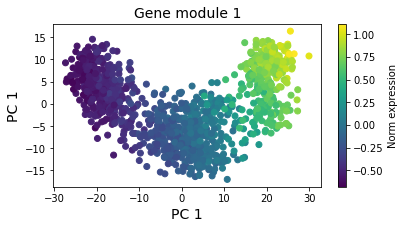

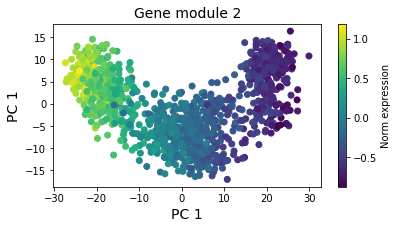

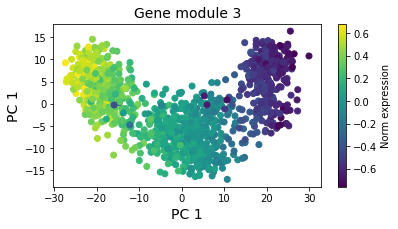

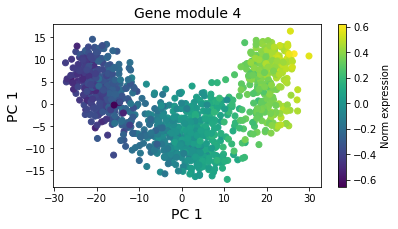

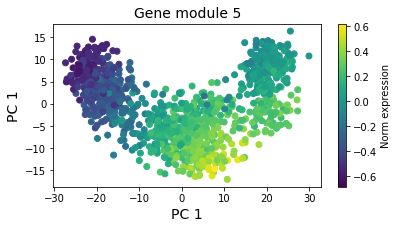

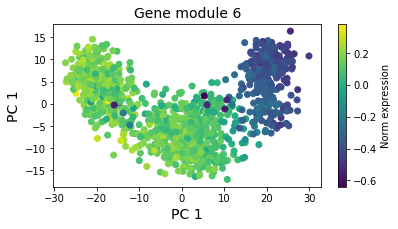

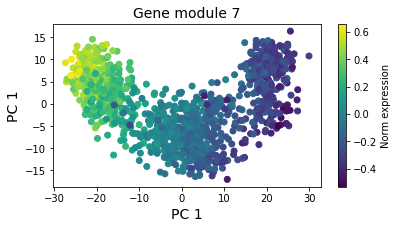

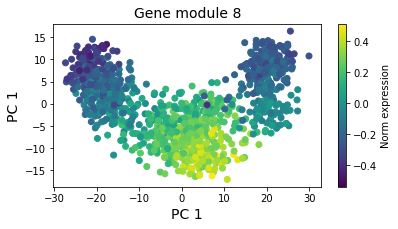

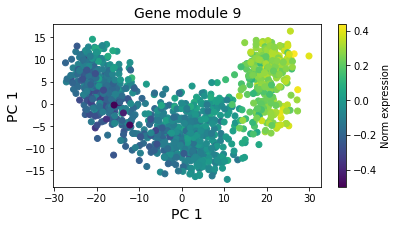

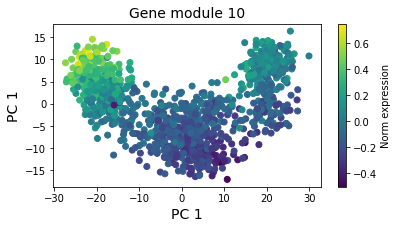

In [27]:
for mod in range(1, 11):
    plt.figure(figsize=(6, 3))
    sc = plt.scatter(latent.PC_1, latent.PC_2,
    c=zscore(norm_expression.loc[modules_genes.loc[modules_genes == mod].index, latent.index], axis=1).mean(axis=0),
           cmap='viridis')
    plt.xlabel('PC 1', fontsize=14)
    plt.ylabel('PC 1', fontsize=14)
    plt.title('Gene module ' + str(mod), fontsize=14)
    plt.colorbar(sc, label='Norm expression')
    plt.savefig('plots/gene_module_' + str(mod) + '.pdf', bbox_inches='tight')
    plt.show()

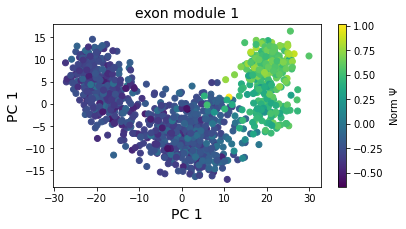

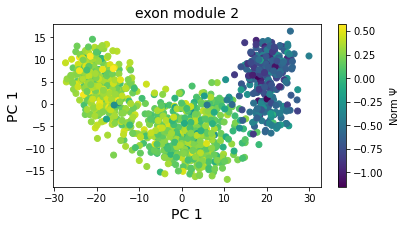

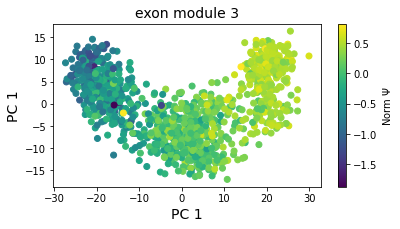

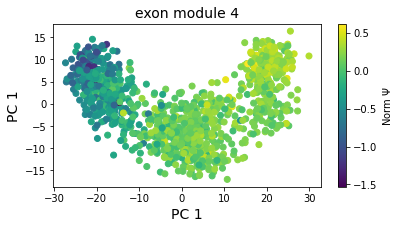

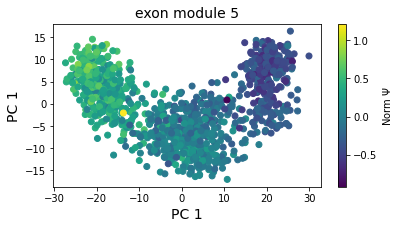

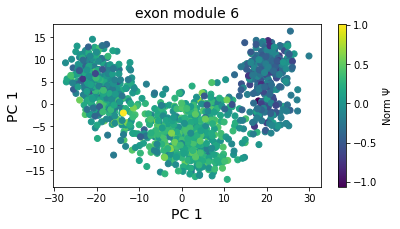

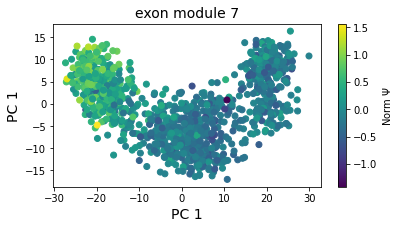

In [36]:
for mod in range(1, 8):
    plt.figure(figsize=(6, 3))
    sc = plt.scatter(latent.PC_1, latent.PC_2,
    c=np.nanmean(zscore(psi.loc[modules_exons.index[modules_exons == mod]], axis=1, 
                                             nan_policy='omit'), axis=0),
           cmap='viridis')
    plt.xlabel('PC 1', fontsize=14)
    plt.ylabel('PC 1', fontsize=14)
    plt.title('exon module ' + str(mod), fontsize=14)
    plt.colorbar(sc, label='Norm $\Psi$')
    plt.savefig('plots/psi_module_' + str(mod) + '.pdf', bbox_inches='tight')
    plt.show()

In [35]:
psi.loc[modules_exons.index[modules_exons == 1]]

,SRR7408400,SRR7408401,SRR7408404,SRR7408413,SRR7408414,SRR7408418,SRR7408422,SRR7408424,SRR7408426,SRR7408427,...,SRR7410086,SRR7410088,SRR7410089,SRR7410090,SRR7410091,SRR7410092,SRR7410093,SRR7410094,SRR7410096,SRR7410097
Mapt_1,0.0,0.0,0.0,0.000000,0.0,0.0,0.055556,0.0,0.000000,0.068966,...,1.000000,1.000000,0.983333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Dbn1_1,0.0,0.0,0.0,0.047619,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,1.000000,1.000000,0.866667,NaN,1.000000,0.000000,0.636364,0.238095,0.000000,1.000000
Ndrg4_1,NaN,0.0,0.0,0.000000,0.0,NaN,NaN,0.0,0.000000,0.000000,...,0.771429,0.828571,0.909091,0.779070,0.888889,0.870130,0.609756,1.000000,0.751938,1.000000
Mapt_3,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.025641,0.000000,...,0.428571,0.000000,0.454545,0.090909,0.555556,0.081081,0.000000,0.259259,0.600000,0.368421
Gabrg2_1,0.0,NaN,NaN,NaN,NaN,0.0,0.000000,0.0,NaN,0.000000,...,0.750000,1.000000,1.000000,1.000000,1.000000,0.545455,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Fam73b_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,1.000000
Btbd6_1,1.0,NaN,1.0,NaN,NaN,NaN,0.250000,1.0,NaN,1.000000,...,1.000000,NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,1.000000
Dlg4_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.000000,NaN,1.000000,1.000000,1.000000,0.000000,NaN,1.000000
Prkcg_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN


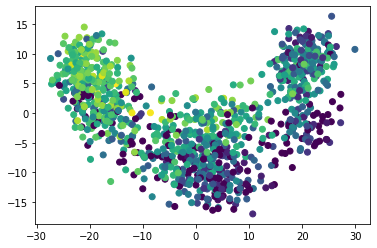

In [23]:
plt.scatter(latent.PC_1, latent.PC_2,
    c=zscore(norm_expression.loc['Nova1', latent.index]),
           cmap='viridis')

In [12]:
module_average_gene = pd.DataFrame()
for i in range(1, 11):
    module_average_gene['Mod_' + str(i)] = np.nanmean(zscore(norm_expression.loc[mod_sf.index[mod_sf == i]], 
                                                 axis=1, nan_policy='omit'), axis=0)
    
module_average_gene = module_average_gene.T
module_average_gene.columns = norm_expression.columns
    
# plt.scatter(latent.PC_1, latent.PC_2, c=psi.loc[modules_exons.index[modules_exons == 7]].mean(), cmap='viridis')

In [14]:
from scipy.stats import pearsonr, spearmanr

In [15]:
splicing_factors = splicing_factors & norm_expression.index

In [16]:
sf_correlation = pd.DataFrame(np.zeros((len(splicing_factors), len(module_average.index))), 
                             index = splicing_factors, columns = module_average.index)

In [17]:
for sf in tqdm(splicing_factors, position=0, leave=True):
    for mod in module_average.index:
        sf_correlation.loc[sf, mod] = spearmanr(module_average.loc[mod], 
                                               norm_expression.loc[sf, module_average.columns])[0]

100%|██████████| 221/221 [00:03<00:00, 61.15it/s]


In [42]:
order = (sf_correlation.Mod_7 - sf_correlation.Mod_1).sort_values().index

In [18]:
from scipy.cluster.hierarchy import linkage

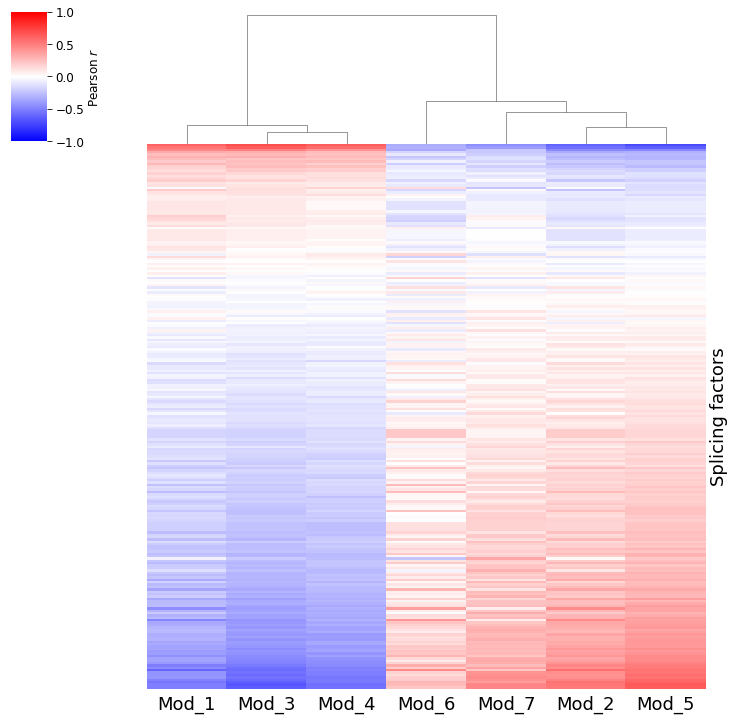

In [71]:
g = sns.clustermap(sf_correlation.loc[order], cmap='bwr', vmax=1, vmin=-1, row_cluster=False, yticklabels=False)
g.ax_heatmap.tick_params(right=False, bottom=False)


# g.ax_heatmap.set_xlabel('Modules', fontsize=18)
g.ax_heatmap.set_ylabel('Splicing factors', fontsize=18)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 18)

g.ax_cbar.set_ylabel('Pearson $r$', fontsize=12)

g.ax_cbar.tick_params(labelsize=12, size=5)

plt.savefig('plots/exon_module_sf_correlation.pdf', bbox_inches='tight')
plt.show()

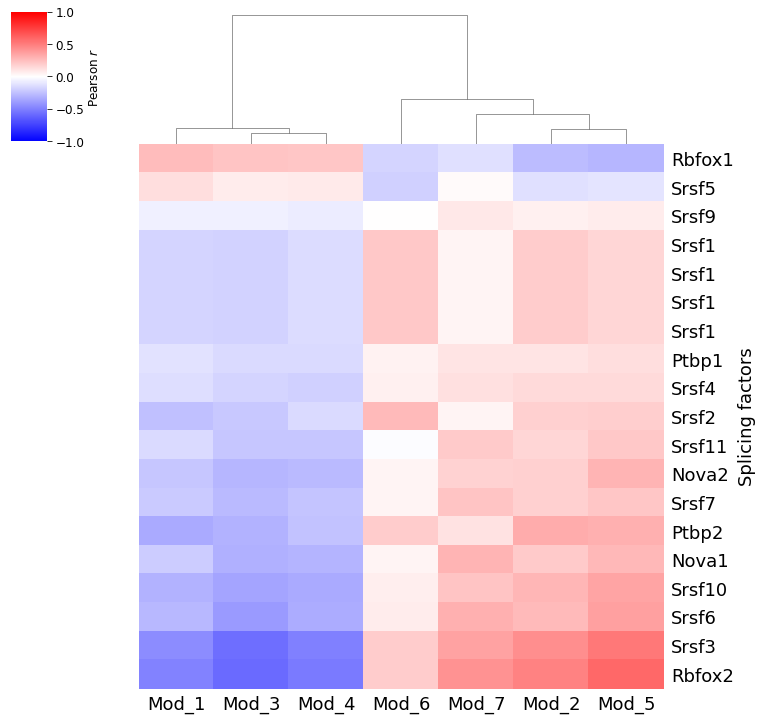

In [72]:
rbp_select = ['Nova1', 'Nova2', 'Rbfox1', 'Rbfox2', 'Rbfox3', 'Mbnl1', 'Mbnl2', 'Ptbp1', 'Ptbp2',
             'Srsf1', 'Srsf2', 'Srsf3', 'Srsf4', 'Srsf5', 'Srsf6', 'Srsf7', 'Srsf9', 'Srsf10', 'Srsf11']
select = [x for x in order if x in rbp_select]

g = sns.clustermap(sf_correlation.loc[select], cmap='bwr', vmax=1, vmin=-1, row_cluster=False)
g.ax_heatmap.tick_params(right=False, bottom=False)


# g.ax_heatmap.set_xlabel('Modules', fontsize=18)
g.ax_heatmap.set_ylabel('Splicing factors', fontsize=18)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 18)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 18, rotation=0)

g.ax_cbar.set_ylabel('Pearson $r$', fontsize=12)

g.ax_cbar.tick_params(labelsize=12, size=5)

plt.savefig('plots/exon_module_selected_sf.pdf', bbox_inches='tight')
plt.show()

In [59]:
sf_correlation_mod = pd.DataFrame(np.zeros((len(module_average_gene.index), len(module_average.index))), 
                             index = module_average_gene.index, columns = module_average.index)

for sf in module_average_gene.index:
    for mod in module_average.index:
        sf_correlation_mod.loc[sf, mod] = spearmanr(module_average.loc[mod], 
                                               module_average_gene.loc[sf, module_average.columns])[0]

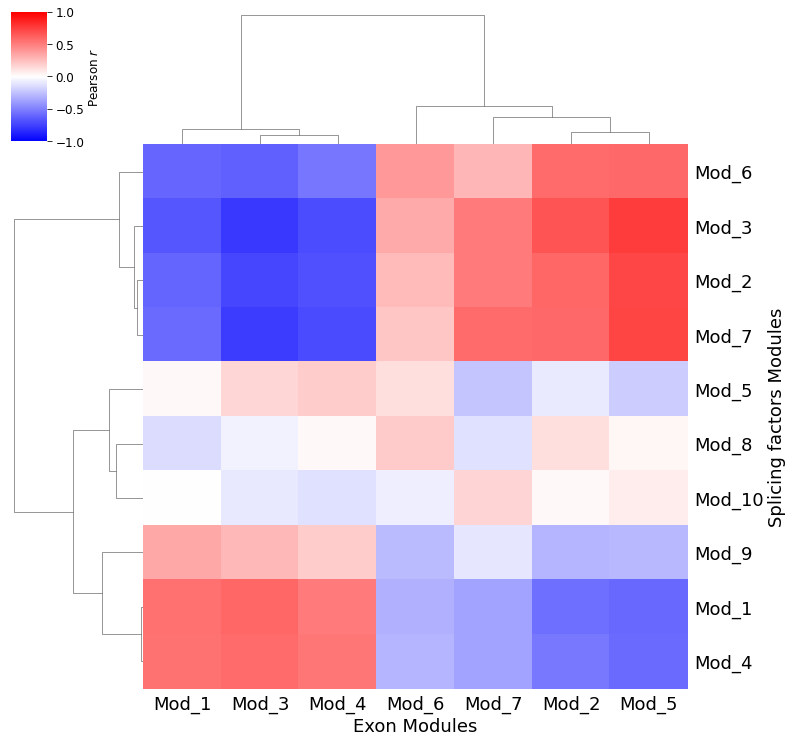

In [69]:
g = sns.clustermap(sf_correlation_mod, cmap='bwr', vmin=-1, vmax=1)

g.ax_heatmap.tick_params(right=False, bottom=False)


# g.ax_heatmap.set_xlabel('Modules', fontsize=18)
g.ax_heatmap.set_ylabel('Splicing factors Modules', fontsize=18)
g.ax_heatmap.set_xlabel('Exon Modules', fontsize=18)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 18)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 18, rotation=0)

g.ax_cbar.set_ylabel('Pearson $r$', fontsize=12)

g.ax_cbar.tick_params(labelsize=12, size=5)

plt.savefig('plots/exon_module_sf_module_correlation.pdf', bbox_inches='tight')
plt.show()

In [111]:
module_average_gene[module_average.columns]

,SRR7408400,SRR7408401,SRR7408404,SRR7408413,SRR7408414,SRR7408418,SRR7408422,SRR7408424,SRR7408426,SRR7408427,...,SRR7410086,SRR7410088,SRR7410089,SRR7410090,SRR7410091,SRR7410092,SRR7410093,SRR7410094,SRR7410096,SRR7410097
Mod_1,1.326467,0.806857,0.968470,0.858070,0.867632,1.038501,0.981320,1.122768,0.965466,0.883132,...,3.294793,2.734945,2.980188,3.864509,3.428134,3.023016,3.529839,3.068265,3.590387,3.125890
Mod_2,2.253360,2.993180,2.712605,2.694947,3.057816,2.303140,2.753228,2.514776,2.762557,2.948123,...,0.774754,0.805601,0.571491,0.534364,0.456706,0.590425,0.647325,0.562570,0.525452,0.827281
Mod_3,2.646798,2.950940,2.958459,2.904028,2.942606,2.624968,2.947794,2.773200,2.840448,2.937995,...,1.322545,1.266608,1.194998,1.007722,1.198487,1.164281,1.209504,1.291986,1.125012,1.341905
Mod_4,1.844180,1.507817,1.731173,1.460681,1.501402,1.752790,1.655277,1.737379,1.604314,1.629763,...,2.834563,2.279354,2.789033,3.155723,2.908804,2.854314,2.889235,2.780380,2.979854,2.782667
Mod_5,1.329710,0.851950,1.096468,0.891005,0.909478,0.928579,0.923616,1.308963,1.077238,0.919017,...,2.042696,1.646149,2.364822,1.774520,1.864116,2.232943,1.807188,2.231468,1.949250,1.878864
Mod_6,2.397868,2.325521,2.462013,2.209932,2.430102,2.192146,2.430963,2.441526,2.341844,2.423391,...,1.583006,1.195097,1.661320,1.391075,1.442459,1.557030,1.489121,1.686563,1.485155,1.573772
Mod_7,2.031370,2.231843,2.273615,2.105955,2.124915,2.090868,2.362908,1.863234,2.038003,2.394217,...,1.248132,1.070284,1.063552,1.105159,0.985005,1.039487,1.292040,1.195679,1.092721,1.246319
Mod_8,1.447776,1.161182,1.364510,1.156592,1.121186,0.966712,1.091459,1.538707,1.197696,1.082993,...,1.422284,1.378574,1.620506,1.136120,1.391667,1.763683,1.337734,1.656472,1.272257,1.520237
Mod_9,1.844812,1.383381,1.714993,1.383725,1.636972,1.845591,1.824200,1.731746,1.557680,1.674374,...,2.151412,1.682021,2.217991,2.442894,2.287249,2.180520,2.238586,2.166336,2.279892,2.201922
Mod_10,1.750368,1.960352,2.309352,1.971648,2.027739,2.188557,2.183352,1.503059,1.650960,2.105407,...,1.464743,1.276206,1.024901,1.508672,1.413229,1.141024,1.647000,1.098213,1.458972,1.249945


# P90 modules

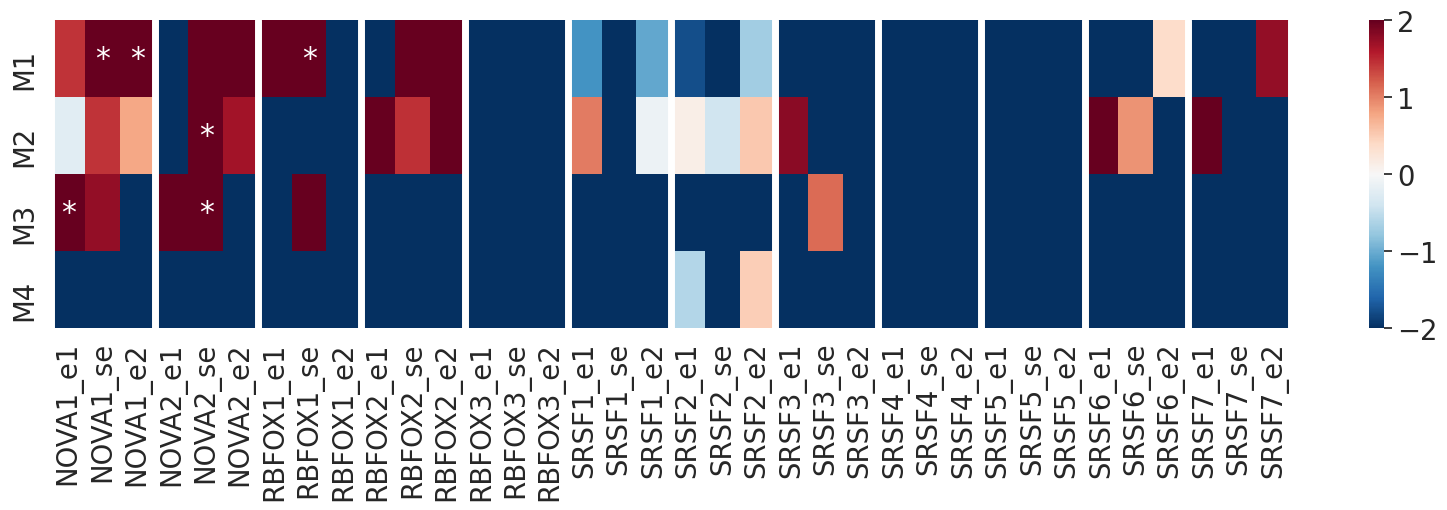

In [198]:
psix_results_p90 = pd.read_csv('psix_object_p90/psix_results.tab.gz', sep='\t', index_col=0)


mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA1_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'NOVA1'])
mouse_clip_families['NOVA1_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'NOVA1'])
mouse_clip_families['NOVA1_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'NOVA1'])

mouse_clip_families['NOVA2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'NOVA2'])
mouse_clip_families['NOVA2_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'NOVA2'])
mouse_clip_families['NOVA2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'NOVA2'])

mouse_clip_families['RBFOX1_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'RBFOX1'])
mouse_clip_families['RBFOX1_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'RBFOX1'])
mouse_clip_families['RBFOX1_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'RBFOX1'])

mouse_clip_families['RBFOX2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'RBFOX2'])
mouse_clip_families['RBFOX2_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'RBFOX2'])
mouse_clip_families['RBFOX2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'RBFOX2'])

mouse_clip_families['RBFOX3_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'RBFOX3'])
mouse_clip_families['RBFOX3_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'RBFOX3'])
mouse_clip_families['RBFOX3_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'RBFOX3'])

mouse_clip_families['SRSF1_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF1'])
mouse_clip_families['SRSF1_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF1'])
mouse_clip_families['SRSF1_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF1'])

mouse_clip_families['SRSF2_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF2'])
mouse_clip_families['SRSF2_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF2'])
mouse_clip_families['SRSF2_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF2'])

mouse_clip_families['SRSF3_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF3'])
mouse_clip_families['SRSF3_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF3'])
mouse_clip_families['SRSF3_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF3'])

mouse_clip_families['SRSF4_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF4'])
mouse_clip_families['SRSF4_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF4'])
mouse_clip_families['SRSF4_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF4'])

mouse_clip_families['SRSF5_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF5'])
mouse_clip_families['SRSF5_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF5'])
mouse_clip_families['SRSF5_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF5'])

mouse_clip_families['SRSF6_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF6'])
mouse_clip_families['SRSF6_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF6'])
mouse_clip_families['SRSF6_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF6'])

mouse_clip_families['SRSF7_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 'SRSF7'])
mouse_clip_families['SRSF7_se'] = np.array(mouse_clip_peaks.loc[se_exons, 'SRSF7'])
mouse_clip_families['SRSF7_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 'SRSF7'])



mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_se')]

modules = pd.read_csv('psix_object/modules_p90.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results_p90.index & mouse_clip_families.index]

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 5):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 5)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 5)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 5)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(4,-4)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

sns.set(font_scale=1.8)

fig = plt.figure(figsize=(20, 4))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

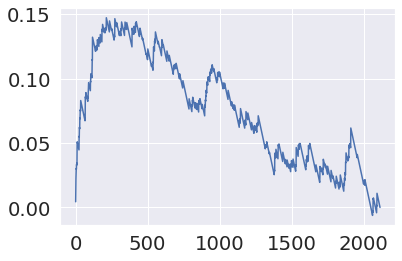

In [172]:
plt.plot(range(len(psix_results_p90)),
    enrichment_score(mouse_clip_overlap.loc[[x + '_se' for x in psix_results_p90.index]].NOVA1))

In [170]:
gsea(mouse_clip_overlap.loc[[x + '_se' for x in psix_results_p90.index]].NOVA1)

100%|██████████| 2000/2000 [00:06<00:00, 333.26it/s]


(0.14713207366800224, 0.0024987506246876563)

In [34]:
neighbors_psi_p90 = pd.read_csv('data/preprocess/tables/neighbors_psi_p90.tab.gz', sep='\t', index_col=0)
psi_p90 = pd.read_csv('data/preprocess/tables/psi_p90.tab.gz', sep='\t', index_col=0)
latent_p90 = pd.read_csv('data/preprocess/tables/p90_pc2_rd.tab.gz', sep='\t', index_col=0)


Text(0.5, 1.0, 'Exon module 1')

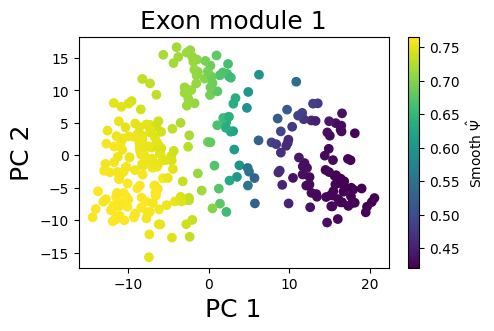

In [196]:
from scipy.stats import zscore
plt.figure(figsize=(5, 3))

sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=neighbors_psi_p90.loc[modules.loc[modules == 1].index, latent_p90.index].mean(axis=0), cmap='viridis')
plt.colorbar(sc, label='Smooth $\hat{\Psi}$')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Exon module 1', fontsize=18)

Text(0.5, 1.0, 'Exon module 2')

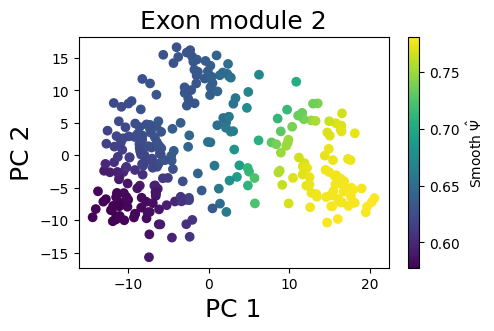

In [195]:
from scipy.stats import zscore
plt.figure(figsize=(5, 3))

sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=neighbors_psi_p90.loc[modules.loc[modules == 2].index, latent_p90.index].mean(axis=0), cmap='viridis')
plt.colorbar(sc, label='Smooth $\hat{\Psi}$')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Exon module 2', fontsize=18)

Text(0.5, 1.0, 'Exon module 3')

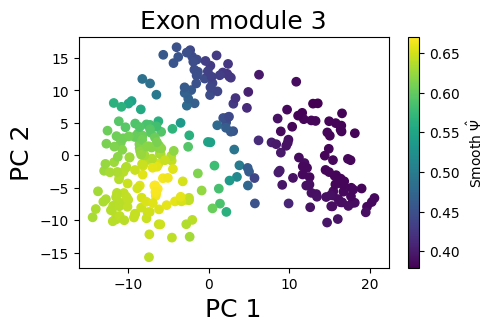

In [191]:
from scipy.stats import zscore
plt.figure(figsize=(5, 3))

sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=neighbors_psi_p90.loc[modules.loc[modules == 3].index, latent_p90.index].mean(axis=0), cmap='viridis')
plt.colorbar(sc, label='Smooth $\hat{\Psi}$')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Exon module 3', fontsize=18)

In [55]:
from sklearn.preprocessing import StandardScaler
scaled_counts_p90 = pd.DataFrame(StandardScaler().fit_transform(norm_expression[latent_p90.index].T).T)
scaled_counts_p90.index = norm_expression.index
scaled_counts_p90.columns = latent_p90.index

hs_p90 = pd.read_csv('psix_object_p90/hotspot_p90.tab.gz', sep='\t', index_col=0)
hs_genes = hs_p90.index[hs_p90.FDR <= 0.01]
smooth_gene = get_background(scaled_counts_p90.loc[hs_genes], latent_p90, n_neighbors=30, remove_self=False).T



slicing exons...


100%|██████████| 885/885 [00:00<00:00, 1420.18it/s]


Text(0.5, 1.0, 'Rbfox1')

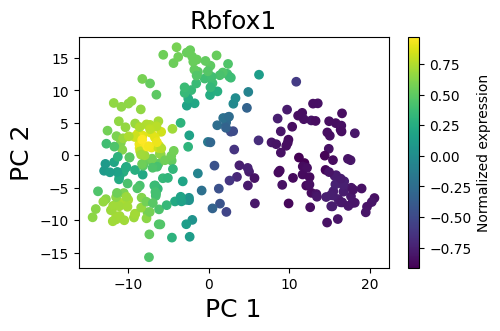

In [182]:
plt.figure(figsize=(5, 3))

sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=smooth_gene.loc['Rbfox1', latent_p90.index], cmap='viridis')
plt.colorbar(sc, label='Normalized expression')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Rbfox1', fontsize=18)

Text(0.5, 1.0, 'Nova1')

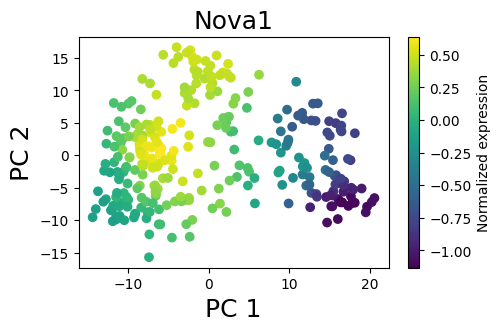

In [184]:
plt.figure(figsize=(5, 3))

sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=smooth_gene.loc['Nova1', latent_p90.index], cmap='viridis')
plt.colorbar(sc, label='Normalized expression')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Nova1', fontsize=18)

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars


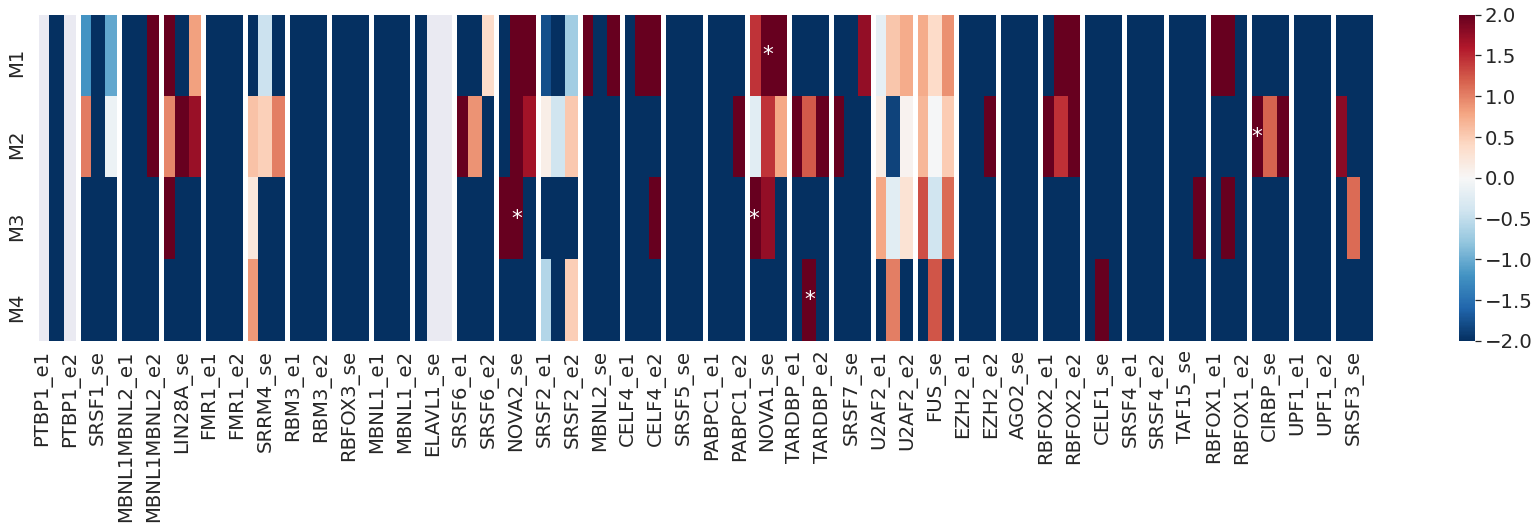

In [66]:
mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags.tab.gz', sep='\t', index_col=0)


mouse_clip_indiv = pd.DataFrame()
for rbp in mouse_clip_peaks.columns:
    mouse_clip_indiv[rbp+'_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, rbp])
    mouse_clip_indiv[rbp+'_se'] = np.array(mouse_clip_peaks.loc[se_exons, rbp])
    mouse_clip_indiv[rbp+'_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, rbp])
    
    mouse_clip_indiv.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_se')]


    
mouse_clip_indiv = mouse_clip_indiv.loc[psix_results_p90.index & mouse_clip_indiv.index]

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_indiv.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 5):
        enrichment = test_enrichment(mouse_clip_indiv[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 5)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 5)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 5)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(4,-4)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

sns.set(font_scale=1.8)

fig = plt.figure(figsize=(30, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 3):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

Text(0.5, 1.0, 'Module 2 (Rbfox1)')

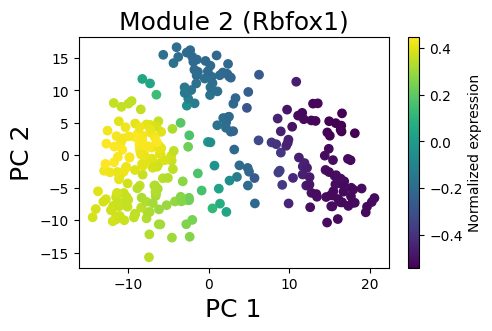

In [201]:
plt.figure(figsize=(5, 3))
modules_genes = pd.read_csv('psix_object/modules_genes_p90.tab.gz', sep='\t', index_col=0).Module

from scipy.stats import zscore
sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=smooth_gene.loc[modules_genes.loc[modules_genes == 2].index, latent_p90.index].mean(axis=0))
plt.colorbar(sc, label='Normalized expression')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Module 2 (Rbfox1)', fontsize=18)

Text(0.5, 1.0, 'Module 5 (Nova1)')

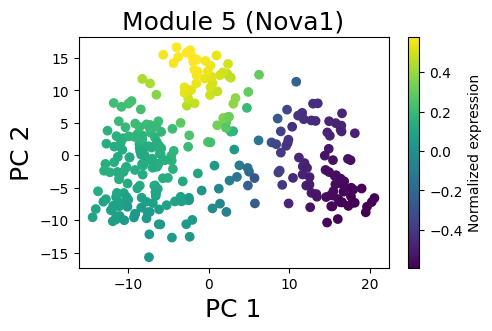

In [202]:
plt.figure(figsize=(5, 3))
modules_genes = pd.read_csv('psix_object/modules_genes_p90.tab.gz', sep='\t', index_col=0).Module

from scipy.stats import zscore
sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=smooth_gene.loc[modules_genes.loc[modules_genes == 5].index, latent_p90.index].mean(axis=0))
plt.colorbar(sc, label='Normalized expression')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Module 5 (Nova1)', fontsize=18)

In [189]:
pd.Index([x.upper() for x in modules_genes.index[modules_genes == 5]]) & mouse_clip_peaks.columns

Index(['NOVA1'], dtype='object')

In [96]:
modules_genes.unique()

array([ 1,  2,  3, -1,  4,  5,  6])

In [200]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [208]:
modules.loc[[x for x in modules.index if 'nmdSE' in x]]

Bnip2_nmdSE_1      1
Rps6kb2_nmdSE_1    1
Stx3_nmdSE_1       1
Vezt_nmdSE_1       3
Spint2_nmdSE_1     1
Name: Module, dtype: int64

In [212]:
np.mean(['nmdSE' in x for x in psix_results_p90.index])

0.08416075650118203

In [214]:
np.mean(['nmdSE' in x for x in modules.index])

0.09259259259259259